In [1]:
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 44.4 MB/s eta 0:00:00


In [2]:
import mne
import numpy as np
import pandas as pd
from mne.preprocessing import ICA

In [3]:
raw = mne.io.read_raw_edf('AKSHARA.edf', preload=True)
raw.set_montage('standard_1020', on_missing='ignore')
raw.filter(l_freq=1., h_freq=None)
notch_freqs = np.arange(60, 121, 60)
raw.notch_filter(notch_freqs, filter_length='auto', phase='zero')

Extracting EDF parameters from /content/AKSHARA.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301823  =      0.000 ...  1178.996 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Measurement date,"October 13, 2023 14:38:33 GMT"
Experimenter,Unknown
Participant,382
Digitized points,19 points
Good channels,32 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,256.00 Hz
Highpass,1.00 Hz
Lowpass,128.00 Hz


In [4]:
marker = pd.read_csv('akshara_data.csv')
my_annot = mne.Annotations(marker['onset'], marker['Duration'], marker['Description'], orig_time=raw.info['meas_date'])
raw.set_annotations(my_annot)

<ipython-input-4-493d0f72ce2f>:3: RuntimeWarning: Omitted 92 annotation(s) that were outside data range.
  raw.set_annotations(my_annot)


Measurement date,"October 13, 2023 14:38:33 GMT"
Experimenter,Unknown
Participant,382
Digitized points,19 points
Good channels,32 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,256.00 Hz
Highpass,1.00 Hz
Lowpass,128.00 Hz


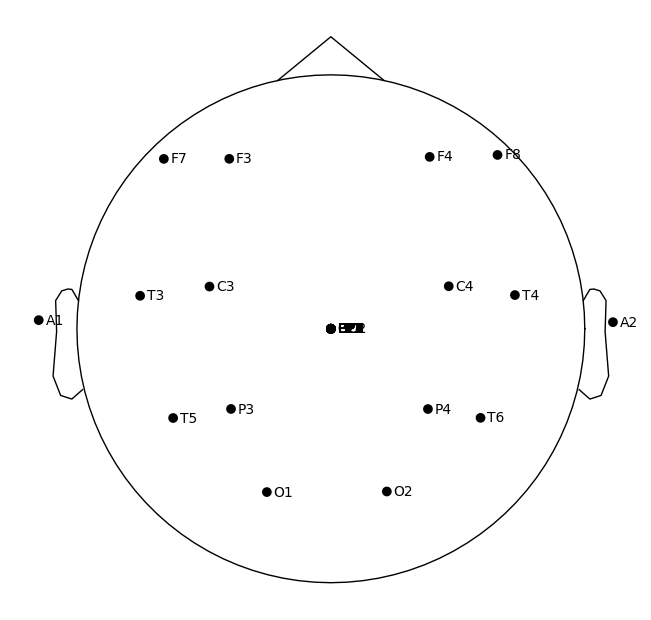

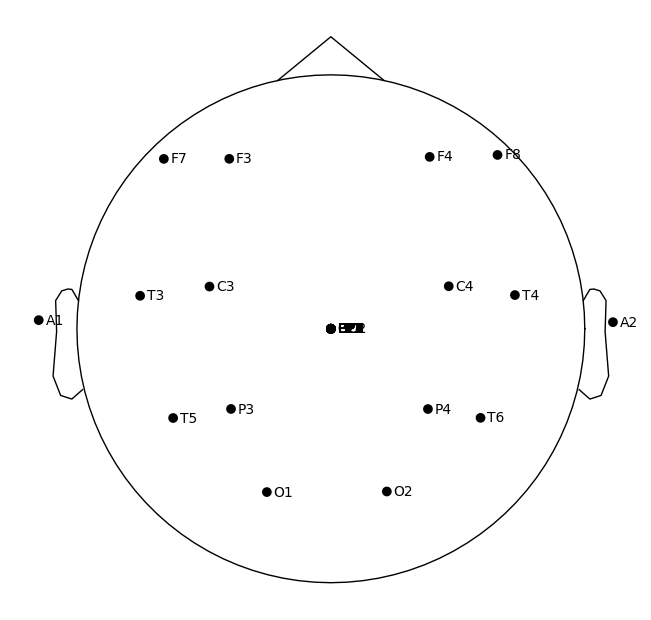

In [5]:
raw.plot_sensors(ch_type='eeg',show_names='True')

Using matplotlib as 2D backend.


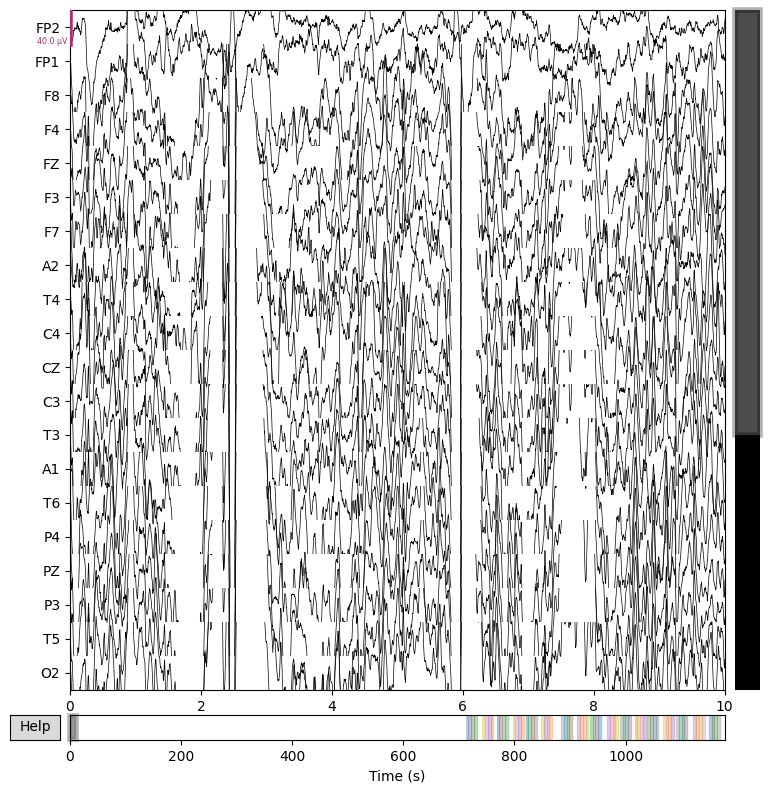

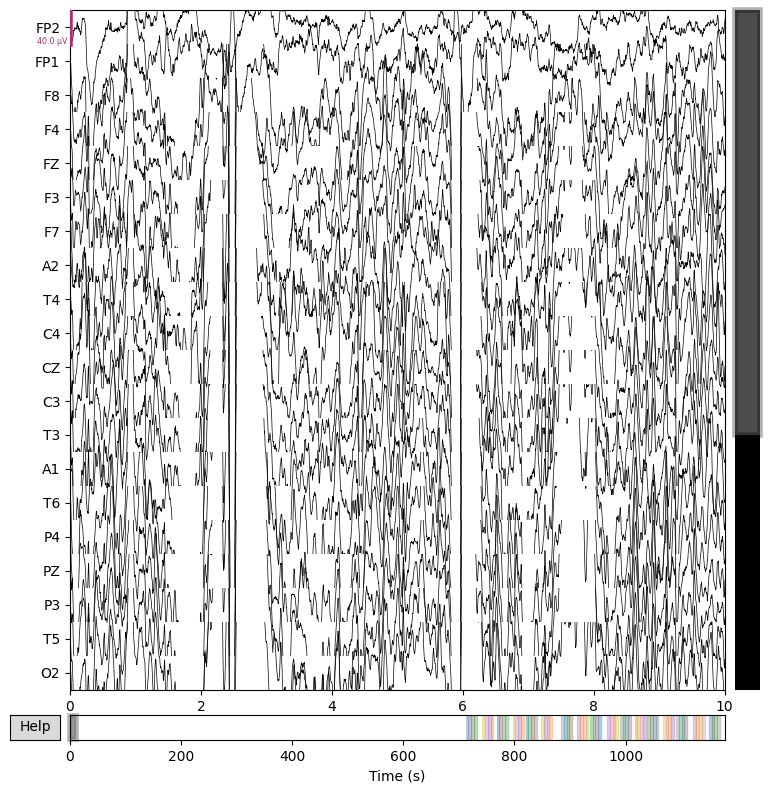

In [7]:
raw.plot()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)


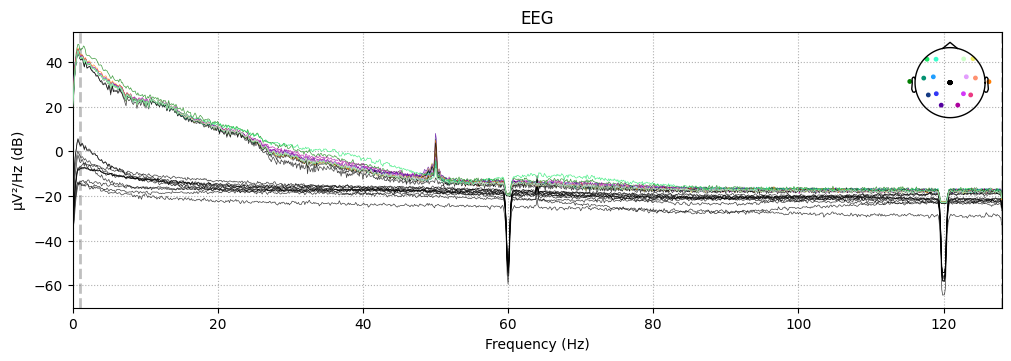

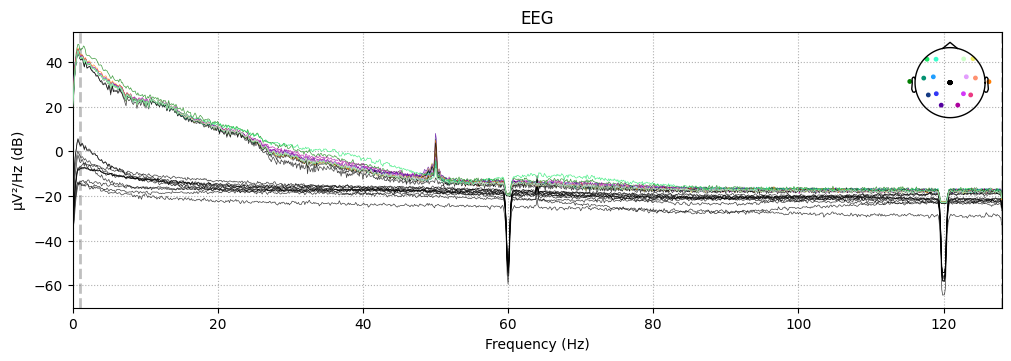

In [8]:
raw.plot_psd()

In [9]:
events, event_id = mne.events_from_annotations(raw)
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=-1., tmax=2., baseline=(None, 0), preload=True)

Used Annotations descriptions: ['LEFTFOOT_ACTION', 'LEFTFOOT_IMAGINE', 'LEFTHAND_ACTION', 'LEFTHAND_IMAGINE', 'RIGHTFOOT_ACTION', 'RIGHTFOOT_IMAGINE', 'RIGHTHAND_ACTION', 'RIGHTHAND_IMAGINE']
Not setting metadata
68 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 68 events and 769 original time points ...
0 bad epochs dropped


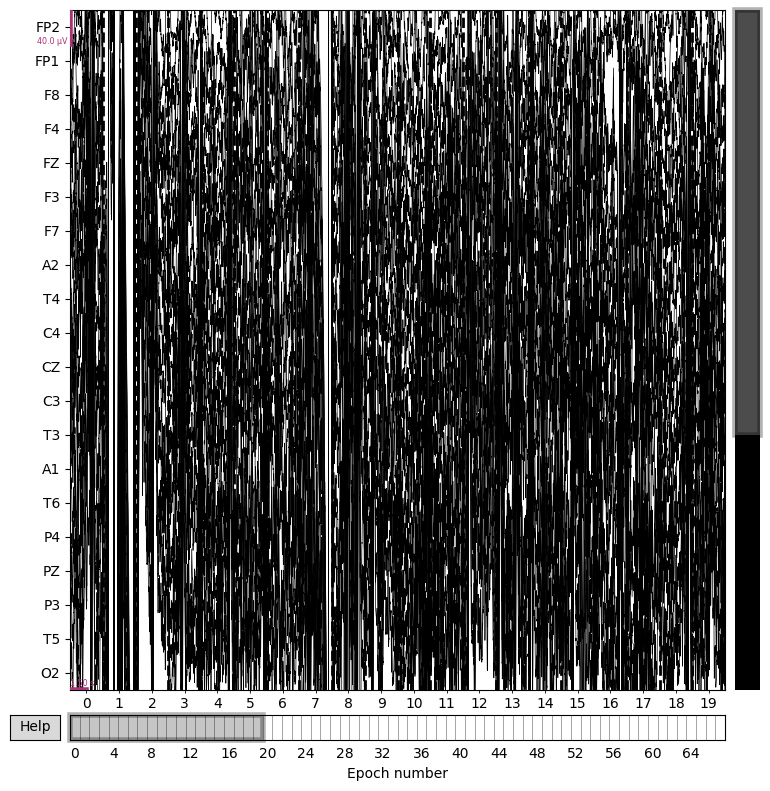

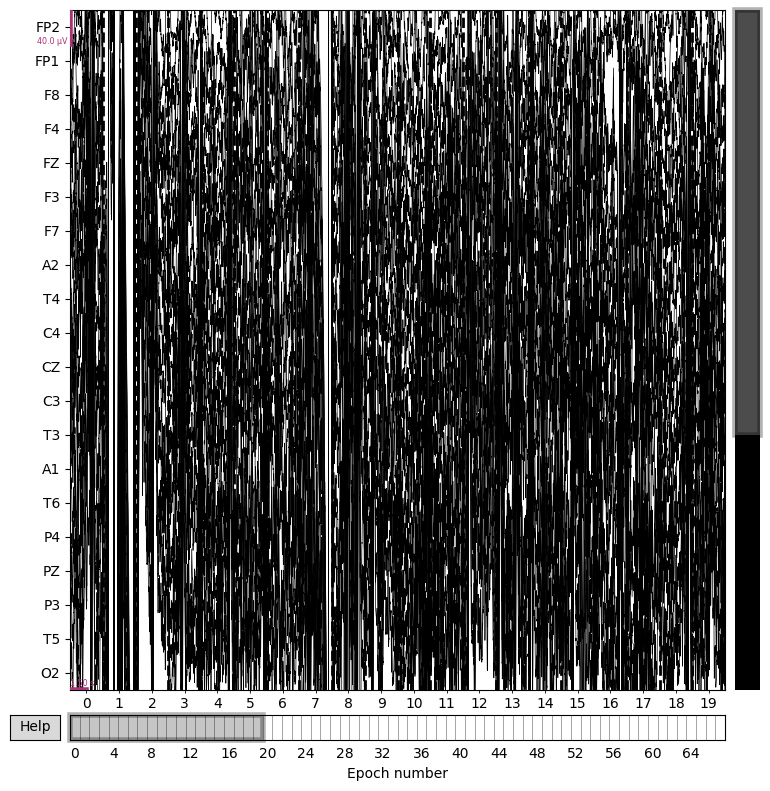

In [11]:
epochs.plot()

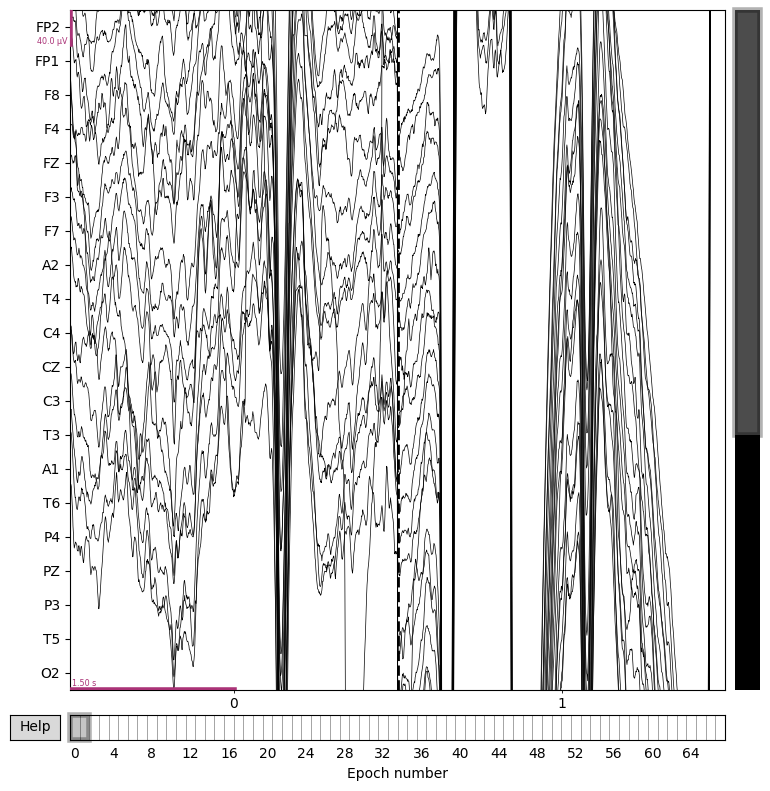

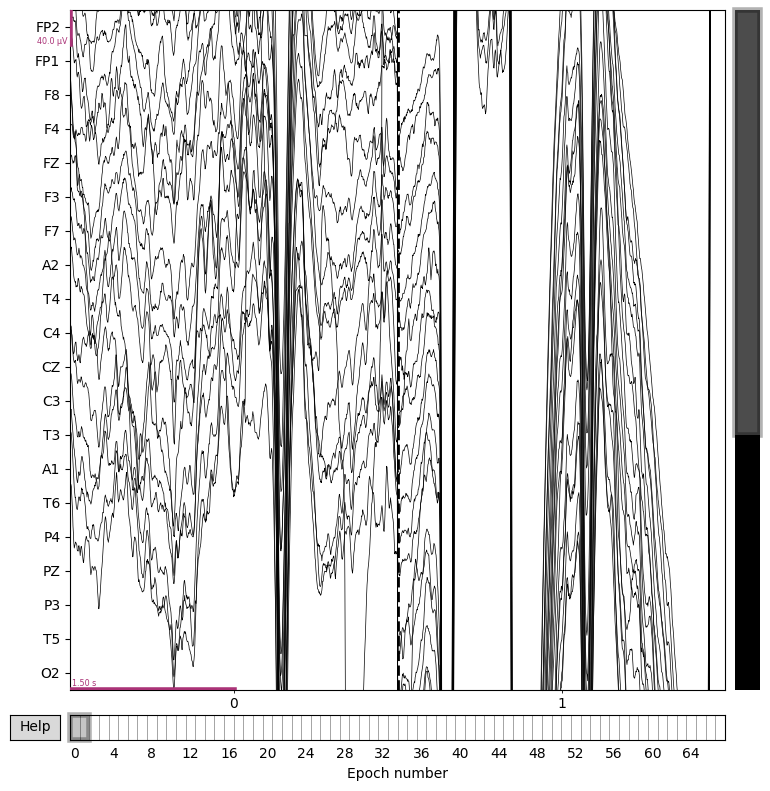

In [14]:
epochs.plot(n_epochs=2)

In [12]:
ica = ICA(n_components=0.95, method='infomax', random_state=97)
ica.fit(epochs)
ica.apply(epochs)
epochs.save("akshara_enhanced_preprocessed_2.fif", overwrite=True)

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by explained variance: 2 components
 


<ipython-input-12-83438e47b82f>:2: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Fitting ICA took 4.9s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 32 PCA components


<ipython-input-12-83438e47b82f>:3: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)
<ipython-input-12-83438e47b82f>:4: RuntimeWarning: This filename (akshara_enhanced_preprocessed_2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save("akshara_enhanced_preprocessed_2.fif", overwrite=True)


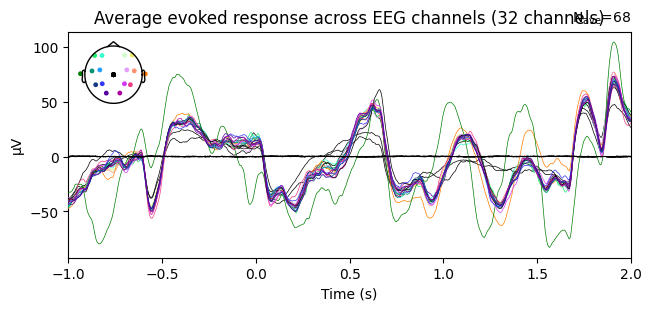

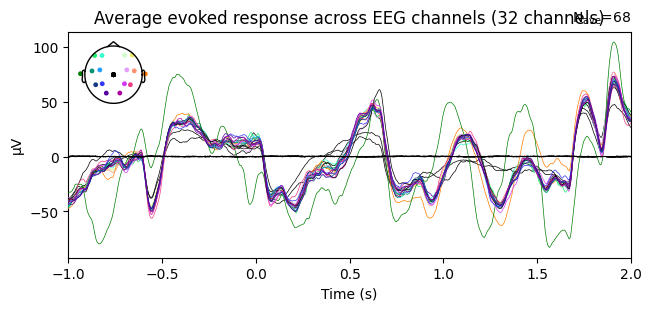

In [32]:
evoked = epochs.average()
evoked.plot(picks='eeg', titles='Average evoked response across EEG channels')

<ipython-input-38-6e79c9897c39>:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  ica_source_data = ica.get_sources(epochs).get_data()


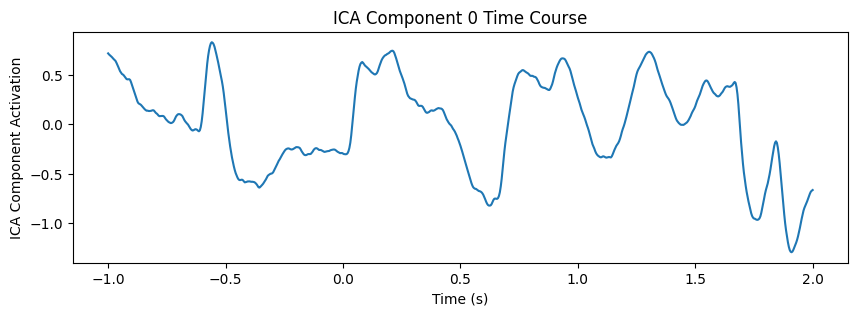

In [38]:
ica_source_data = ica.get_sources(epochs).get_data()
component_idx = 0
ica_component_average = ica_source_data[:, component_idx, :].mean(axis=0)

import matplotlib.pyplot as plt

times = epochs.times
plt.figure(figsize=(10, 3))
plt.plot(times, ica_component_average)
plt.xlabel("Time (s)")
plt.ylabel("ICA Component Activation")
plt.title(f"ICA Component {component_idx} Time Course")
plt.show()


In [39]:
import mne
epochs = mne.read_epochs('./akshara_enhanced_preprocessed_2.fif')
import numpy as np

X = epochs.get_data()

events = epochs.events
labels = events[:, -1]

event_id_mapping = {
    1: 'left hand',
    2: 'right hand',
    3: 'left leg',
    4: 'right leg',
    5: 'imaginary left hand',
    6: 'imaginary right hand',
    7: 'imaginary left leg',
    8: 'imaginary right leg',
}

y = np.array([event_id_mapping[event_id] for event_id in labels])

Reading /content/akshara_enhanced_preprocessed_2.fif ...
    Found the data of interest:
        t =   -1000.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-39-769025a8c1ed>:2: RuntimeWarning: This filename (./akshara_enhanced_preprocessed_2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs('./akshara_enhanced_preprocessed_2.fif')
<ipython-input-39-769025a8c1ed>:5: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = epochs.get_data()


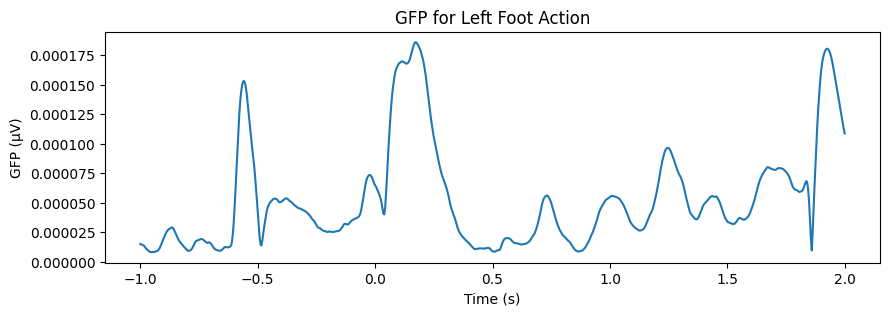

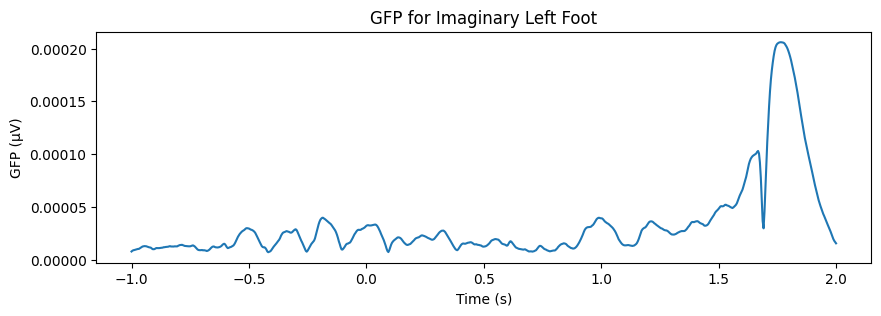

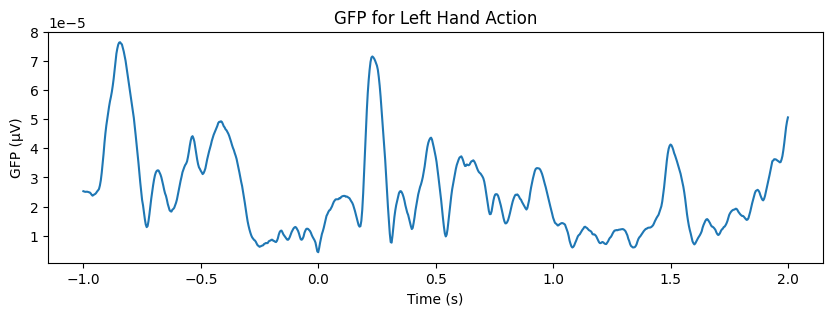

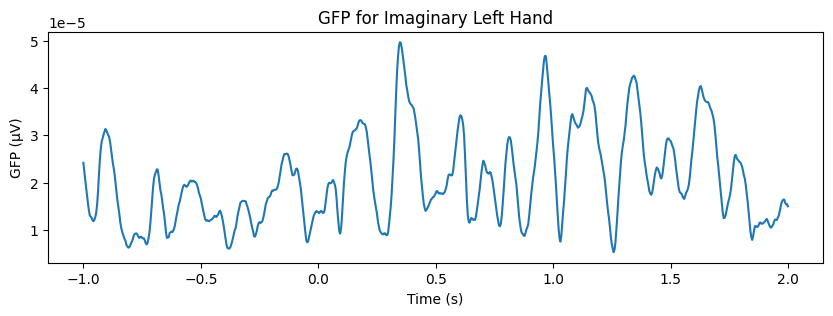

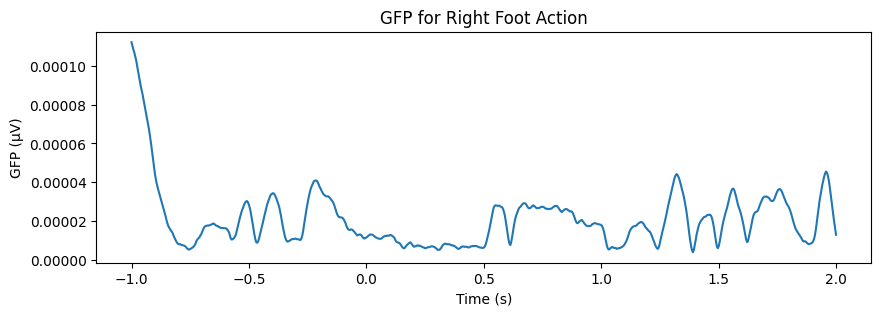

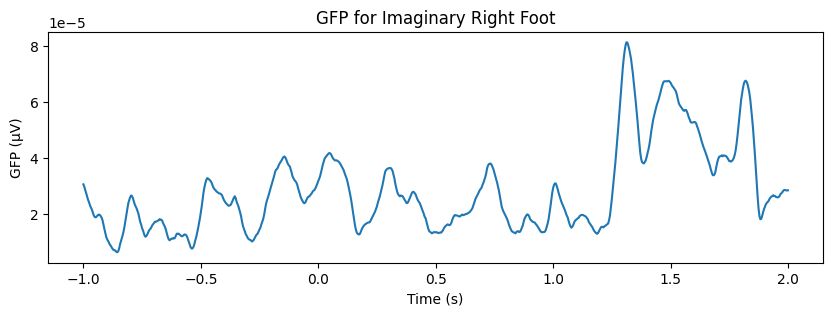

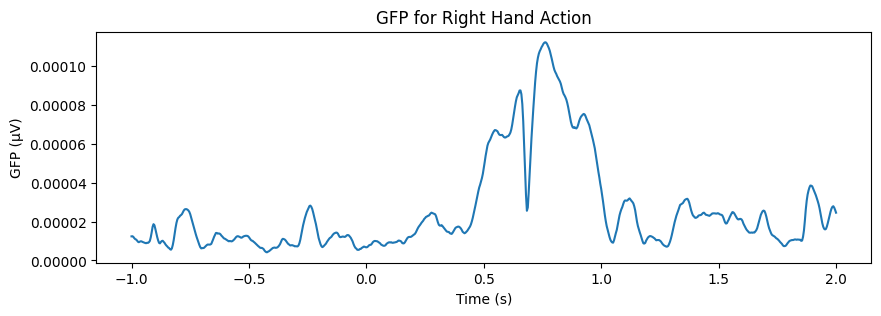

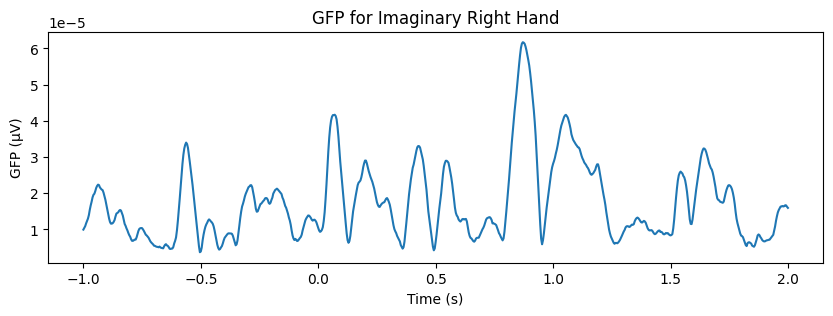

In [45]:
import matplotlib.pyplot as plt

# Loop through each unique event type by name
for event_name in event_id_mapping.keys():
    # Find epochs corresponding to the current event type
    specific_epochs = epochs[event_name]

    # Calculate the average over these epochs to get an Evoked object
    evoked = specific_epochs.average()

    # Plot the Global Field Power
    plt.figure(figsize=(10, 3))
    gfp = np.std(evoked.data, axis=0)
    plt.plot(evoked.times, gfp)
    plt.title(f"GFP for {event_id_mapping[event_name]}")
    plt.xlabel("Time (s)")
    plt.ylabel("GFP (µV)")
    plt.show()


In [46]:
print(X.shape)
print(y.shape)

(68, 32, 769)
(68,)


In [47]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

selector = SelectKBest(score_func=f_classif, k=49)
X_selected = selector.fit_transform(X.reshape(X.shape[0], -1), y)

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)

predictions = knn_classifier.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


Accuracy: 0.14285714285714285


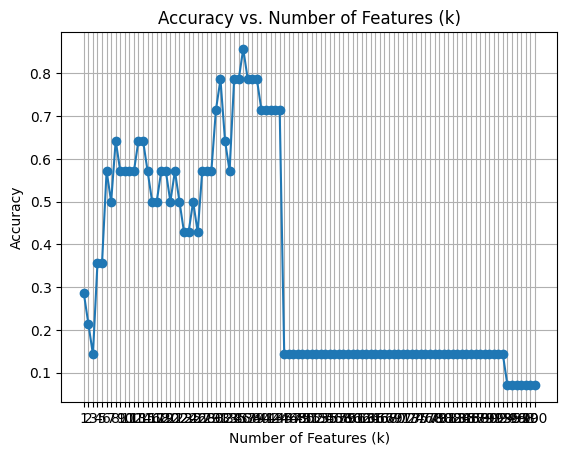

In [48]:
import matplotlib.pyplot as plt

k_values = range(1, 101)
accuracies = []

for k in k_values:
    selector = SelectKBest(score_func=f_classif, k=k)
    X_selected = selector.fit_transform(X.reshape(X.shape[0], -1), y)

    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    knn_classifier = KNeighborsClassifier()
    knn_classifier.fit(X_train, y_train)

    predictions = knn_classifier.predict(X_test)

    accuracy = accuracy_score(y_test, predictions)
    accuracies.append(accuracy)

plt.plot(k_values, accuracies, marker='o')
plt.title('Accuracy vs. Number of Features (k)')
plt.xlabel('Number of Features (k)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()


In [49]:
max_accuracy_index = accuracies.index(max(accuracies))

best_k = k_values[max_accuracy_index]

print("Best k value with maximum accuracy:", best_k)
print("Maximum accuracy:", max(accuracies))


Best k value with maximum accuracy: 36
Maximum accuracy: 0.8571428571428571


In [50]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn1 = KNeighborsClassifier()
knn2 = KNeighborsClassifier()
knn3 = KNeighborsClassifier()

stacked_classifier = StackingClassifier(estimators=[('knn1', knn1), ('knn2', knn2), ('knn3', knn3)])

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('stacked_classifier', stacked_classifier)
])

param_grid = {
    'pca__n_components': [5, 10, 15],
    'stacked_classifier__knn1__n_neighbors': [5, 10, 15],
    'stacked_classifier__knn2__n_neighbors': [5, 10, 15],
    'stacked_classifier__knn3__n_neighbors': [5, 10, 15,25]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_selected, y)

print("Best parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
predictions = best_model.predict(X_selected)
accuracy = accuracy_score(y, predictions)
print("Accuracy:", accuracy)


Best parameters: {'pca__n_components': 10, 'stacked_classifier__knn1__n_neighbors': 5, 'stacked_classifier__knn2__n_neighbors': 10, 'stacked_classifier__knn3__n_neighbors': 15}
Accuracy: 0.9705882352941176
